# **뉴스 기사 분류 : 다중 분류**

In [ ]:
import keras
keras.__version__

'2.4.3'

##  * Reuters dataset

In [ ]:
from keras.datasets import reuters

# 가장 자주 등장하는 단어 10,000개
(traindata,trainlabels),(testdata,testlabels) = reuters.load_data(num_words=10000)

2113536/2110848 [==============================] - 0s 0us/step


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [ ]:
print(len(traindata))
print(len(testdata))

8982
2246


In [ ]:
# 단어 리스트가 아니라, 단어 인덱스인 정수 리스트로 이루어진 데이터
print(traindata[0])
print()
# label은 토픽의 인덱스(0~45 정수)
print(trainlabels[0])

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]

3


+) 단어 인덱스를 단어로 디코딩하는 방법

In [ ]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value,key) for (key,value) in word_index.items()])
decoded_newswire = ' '.join([reverse_word_index.get(i-3, '?') for i in traindata[0]])
# 0,1,2 는 불필요한 인덱스이므로 제외

In [ ]:
decoded_newswire

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

##  * Preprocessing (vectorize)

1) 데이터를 벡터로 변환

In [ ]:
import numpy as np

def vectorize_sequences(seq,dimention=10000):
  res = np.zeros((len(seq),dimention)) # 영행렬 생성
  for i, seq in enumerate(seq):
    res[i,seq] = 1. # 해당 원소를 1로 변경
  return res

xtrain = vectorize_sequences(traindata)
xtest = vectorize_sequences(testdata)

In [ ]:
xtrain[0]

array([0., 1., 1., ..., 0., 0., 0.])

In [ ]:
xtest[0]

array([0., 1., 1., ..., 0., 0., 0.])

2) label을 벡터로 변환

In [ ]:
# 2-1) 함수 생성

def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

one_hot_train_labels = to_one_hot(trainlabels)
one_hot_test_labels = to_one_hot(testlabels)

In [ ]:
one_hot_train_labels[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
# 2-2) keras 내장 함수 사용

from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(trainlabels)
one_hot_test_labels = to_categorical(testlabels)

##  * 모델 구성

In [ ]:
from keras import models, layers

model = models.Sequential()
# 세개의 Dense 층으로 이루어진 모델
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax')) # 각 입력 데이터마다 46개의 labeel로 분류될 확률 분포를 출력

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                640064    
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 46)                2990      
Total params: 647,214
Trainable params: 647,214
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# categorical_crossentropy : 모델이 출력한 확률 분포와 진짜 label의 분포 사이의 거리 측정

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

##  * 훈련 검증

In [ ]:
# validation set 생성 (처음 본 데이터)

xvalid = xtrain[:1000]
partial_xtrain = xtrain[1000:]

yvalid = one_hot_train_labels[:1000]
partial_ytrain = one_hot_train_labels[1000:]

In [ ]:
# 20 epochs 반복
history = model.fit(partial_xtrain,
                    partial_ytrain,
                    epochs=20,
                    batch_size=512,
                    validation_data = (xvalid, yvalid))

Epoch 1/20
16/16 [==============================] - 2s 58ms/step - loss: 3.0881 - accuracy: 0.4225 - val_loss: 1.7455 - val_accuracy: 0.6540
Epoch 2/20
16/16 [==============================] - 1s 44ms/step - loss: 1.5018 - accuracy: 0.7023 - val_loss: 1.3196 - val_accuracy: 0.7110
Epoch 3/20
16/16 [==============================] - 1s 44ms/step - loss: 1.1020 - accuracy: 0.7604 - val_loss: 1.1366 - val_accuracy: 0.7500
Epoch 4/20
16/16 [==============================] - 1s 44ms/step - loss: 0.8611 - accuracy: 0.8147 - val_loss: 1.0363 - val_accuracy: 0.7740
Epoch 5/20
16/16 [==============================] - 1s 46ms/step - loss: 0.6891 - accuracy: 0.8512 - val_loss: 0.9784 - val_accuracy: 0.7810
Epoch 6/20
16/16 [==============================] - 1s 44ms/step - loss: 0.5653 - accuracy: 0.8812 - val_loss: 0.9252 - val_accuracy: 0.8050
Epoch 7/20
16/16 [==============================] - 1s 44ms/step - loss: 0.4653 - accuracy: 0.9018 - val_loss: 0.8997 - val_accuracy: 0.8120
Epoch 8/20
16

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

1) 손실 곡선

In [ ]:
import matplotlib.pyplot as plt

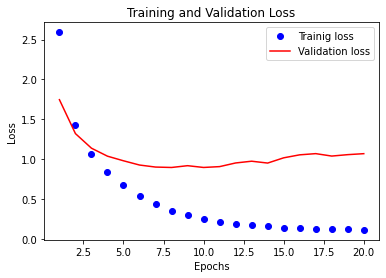

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1) # 1~len(loss)

plt.plot(epochs, loss, 'bo', label='Trainig loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs') # 반복횟수
plt.ylabel('Loss')
plt.legend()

2) 정확도 곡선

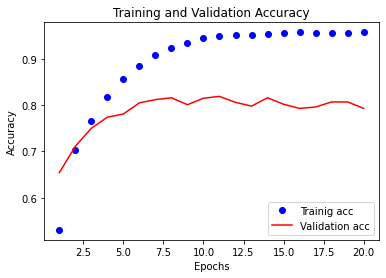

In [ ]:
plt.clf()  # 그래프 초기화

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1,len(loss)+1) # 1~len(loss)

plt.plot(epochs, acc, 'bo', label='Trainig acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs') # 반복횟수
plt.ylabel('Accuracy')
plt.legend()

그래프의 기울기를 보녀, 9번째 epoch 이후로 과대적합이 시작됨을 알 수 있다.  
epoch를 9로 조정해 새로운 모델을 훈련하고, 평가한다.

In [ ]:
model = models.Sequential()
# 세개의 Dense 층으로 이루어진 모델
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax')) # 각 입력 데이터마다 46개의 labeel로 분류될 확률 분포를 출력

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 9 epochs 반복
history = model.fit(partial_xtrain,
                    partial_ytrain,
                    epochs=9,
                    batch_size=512,
                    validation_data = (xvalid, yvalid))

# 평가 결과 
results = model.evaluate(xtest,one_hot_test_labels)

Epoch 1/9
16/16 [==============================] - 1s 55ms/step - loss: 2.9823 - accuracy: 0.4442 - val_loss: 1.6548 - val_accuracy: 0.6450
Epoch 2/9
16/16 [==============================] - 1s 44ms/step - loss: 1.4611 - accuracy: 0.6901 - val_loss: 1.2987 - val_accuracy: 0.7120
Epoch 3/9
16/16 [==============================] - 1s 44ms/step - loss: 1.0567 - accuracy: 0.7646 - val_loss: 1.1405 - val_accuracy: 0.7460
Epoch 4/9
16/16 [==============================] - 1s 44ms/step - loss: 0.8544 - accuracy: 0.8148 - val_loss: 1.0363 - val_accuracy: 0.7830
Epoch 5/9
16/16 [==============================] - 1s 44ms/step - loss: 0.6994 - accuracy: 0.8498 - val_loss: 0.9778 - val_accuracy: 0.7860
Epoch 6/9
16/16 [==============================] - 1s 44ms/step - loss: 0.5342 - accuracy: 0.8844 - val_loss: 0.9341 - val_accuracy: 0.8050
Epoch 7/9
16/16 [==============================] - 1s 45ms/step - loss: 0.4205 - accuracy: 0.9136 - val_loss: 0.9072 - val_accuracy: 0.8090
Epoch 8/9
16/16 [===

In [ ]:
# 평가 결과 출력 : 약 79%의 정확도
results

[0.9744585156440735, 0.7853962779045105]

##  * 새로운 데이터에 대해 예측하기

In [ ]:
# model.predict() : 46개 토픽에 대한 확률 분포를 반환
predictions = model.predict(xtest)

predictions[0] # 각 항목의 길이가 46인 벡터

array([8.0643458e-06, 1.2377423e-04, 7.9198129e-05, 7.0144653e-01,
       2.8092146e-01, 4.7700651e-05, 1.1964727e-05, 5.8791356e-04,
       2.2909408e-03, 1.2555810e-05, 1.3494815e-04, 5.0310465e-04,
       9.0041227e-05, 7.4884348e-04, 4.4802565e-04, 1.6001421e-04,
       6.1272661e-04, 5.3050258e-05, 9.0959882e-05, 2.3383400e-03,
       5.5039972e-03, 2.3315927e-04, 5.2998173e-05, 1.4609197e-03,
       2.4393463e-04, 1.6691954e-05, 3.6341748e-06, 2.2292485e-05,
       1.0865500e-04, 2.0798777e-04, 2.0186472e-04, 7.3352974e-05,
       9.8305372e-06, 4.9345061e-05, 1.1966638e-04, 7.8460645e-05,
       3.7676375e-04, 1.3853565e-05, 2.5291911e-05, 1.4380892e-04,
       7.6031873e-05, 2.0033792e-04, 7.5500752e-06, 4.8801816e-05,
       7.2980047e-06, 3.4164245e-06], dtype=float32)

In [ ]:
# 확률 분포이므로 46개 모든 원소의 합은 1
np.sum(predictions[0])

1.0000001

In [ ]:
# 확률이 가장 높은 값이 예측 클래스가 된다.
np.argmax(predictions[10])

1

##  +) label을 인코딩 하는 다른 방법

In [ ]:
# label을 정수 텐서로 변환
ytrain = np.array(trainlabels)
ytest = np.array(testlabels)

# loss 함수를 categorical_crossentropy 에서 sparse_categorical_crossentropy 로 변경
model.compile(optimizer='rmsprop', 
              loss='sparse_categorical_crossentropy', 
              metrics=['acc'])

numpy.ndarray

##  +) 중간층의 hidden unit이 충분히 커야 하는 이유

In [ ]:
# 중간층을 46차원 -> 4차원 으로 변경해서 실험
# val_acc가 약 73%로 감소한 것을 알 수 있음

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_xtrain,
          partial_ytrain,
          epochs=20,
          batch_size=128,
          validation_data=(xvalid, yvalid))

Epoch 1/20
63/63 [==============================] - 2s 19ms/step - loss: 3.6266 - accuracy: 0.0857 - val_loss: 2.6308 - val_accuracy: 0.4280
Epoch 2/20
63/63 [==============================] - 1s 15ms/step - loss: 2.2593 - accuracy: 0.4502 - val_loss: 1.7313 - val_accuracy: 0.4930
Epoch 3/20
63/63 [==============================] - 1s 18ms/step - loss: 1.4660 - accuracy: 0.5842 - val_loss: 1.4286 - val_accuracy: 0.6510
Epoch 4/20
63/63 [==============================] - 1s 16ms/step - loss: 1.1762 - accuracy: 0.7109 - val_loss: 1.3250 - val_accuracy: 0.6920
Epoch 5/20
63/63 [==============================] - 1s 16ms/step - loss: 1.0183 - accuracy: 0.7383 - val_loss: 1.2848 - val_accuracy: 0.6940
Epoch 6/20
63/63 [==============================] - 1s 16ms/step - loss: 0.9061 - accuracy: 0.7748 - val_loss: 1.2634 - val_accuracy: 0.7080
Epoch 7/20
63/63 [==============================] - 1s 16ms/step - loss: 0.8071 - accuracy: 0.7988 - val_loss: 1.2820 - val_accuracy: 0.7190
Epoch 8/20
63

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                640064    
_________________________________________________________________
dense_13 (Dense)             (None, 4)                 260       
_________________________________________________________________
dense_14 (Dense)             (None, 46)                230       
Total params: 640,554
Trainable params: 640,554
Non-trainable params: 0
_________________________________________________________________
